## Multi Head Attention

Multi-Head Attention model works by applying multiple attention mechanisms (or "heads") in parallel to the input sequence. Each head learns to focus on different parts of the input independently, and their outputs are concatenated and passed through a linear layer to produce the final result.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

In [2]:
# Example Configuration
batch_size = 32
seq_len = 10
d_model = 512
num_heads = 8
d_head = d_model // num_heads  # d_head = 512 / 8 = 64

#### 1. Input
The input to the attention layer is a matrix of shape **(batch_size, seq_len, d_model)**, where:

- **batch_size**: Number of samples in the batch.
- **seq_len**: Length of the input sequence.
- **d_model**: Dimensionality of the input embeddings.

For example:
- Input shape: **(32, 10, 512)** (batch size = 32, sequence length = 10, and model dimension = 512).

In [3]:
# Step 1: Input (random tensor simulating the embeddings)
input_tensor = torch.randn(batch_size, seq_len, d_model)  # Shape: (batch_size, seq_len, d_model)
input_tensor.shape

torch.Size([32, 10, 512])

#### 2. Linear Projections for Q, K, and V
The input is projected into three matrices: **Query (Q)**, **Key (K)**, and **Value (V)**, each of dimension **(batch_size, seq_len, d_model)**.

Each of Q, K, and V are obtained by multiplying the input matrix by learnable weight matrices, so the dimensions of each are still **(batch_size, seq_len, d_model)**.

For example:
- Q, K, V shapes: **(32, 10, 512)**.

In [4]:
# Step 2: Linear Projections for Q, K, and V
# Create 3 separate weight matrices for Query, Key, and Value, which will be learned.
# Each of these weight matrices will have shape (d_model, d_model) for Q, K, V.

W_q = nn.Linear(d_model, d_model)
W_k = nn.Linear(d_model, d_model)
W_v = nn.Linear(d_model, d_model)

Q = W_q(input_tensor)  # Shape: (batch_size, seq_len, d_model)
K = W_k(input_tensor)  # Shape: (batch_size, seq_len, d_model)
V = W_v(input_tensor)  # Shape: (batch_size, seq_len, d_model)

Q.shape, K.shape, V.shape

(torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]),
 torch.Size([32, 10, 512]))

#### 3. Splitting into Heads
To apply multi-head attention, we split the model dimension **d_model** into **num_heads** heads. Suppose we want **num_heads = 8** and **d_model = 512**, so each head will have a dimension of **d_head = d_model / num_heads = 512 / 8 = 64**.

The matrices Q, K, and V are split into **num_heads** parts, resulting in each head having a dimension of **(batch_size, seq_len, d_head)**.

For example:
- Q, K, V shapes after splitting: **(32, 10, 64)** for each head.

Now, we have **num_heads = 8** heads, so each head has a shape of **(32, 10, 64)**. For 8 heads, this becomes a shape of **(batch_size, num_heads, seq_len, d_head)**.

For example:
- Q, K, V for 8 heads: **(32, 8, 10, 64)**.

In [5]:
# Step 3: Splitting into Heads (num_heads = 8, d_head = 64)
# Reshape Q, K, and V to split them into heads, which will have shape (batch_size, num_heads, seq_len, d_head).

Q = Q.reshape(batch_size, seq_len, num_heads, d_head).permute(0, 2, 1, 3)  # Shape: (batch_size, num_heads, seq_len, d_head)
K = K.reshape(batch_size, seq_len, num_heads, d_head).permute(0, 2, 1, 3)  # Shape: (batch_size, num_heads, seq_len, d_head)
V = V.reshape(batch_size, seq_len, num_heads, d_head).permute(0, 2, 1, 3)  # Shape: (batch_size, num_heads, seq_len, d_head)

Q.shape, K.shape, V.shape

(torch.Size([32, 8, 10, 64]),
 torch.Size([32, 8, 10, 64]),
 torch.Size([32, 8, 10, 64]))

#### 4. Scaled Dot-Product Attention
Each head computes the scaled dot-product attention between the corresponding Query (Q) and Key (K) matrices. The result of this attention is a matrix of shape **(batch_size, num_heads, seq_len, seq_len)**.

- The **Q** matrix has the shape **(batch_size, num_heads, seq_len, d_head)**, and the **K** matrix has the shape **(batch_size, num_heads, seq_len, d_head)**.
- When performing the attention, we compute the dot product between each **Query** and **Key** for every position in the sequence. This results in a matrix of size **(batch_size, num_heads, seq_len, seq_len)**, where each **seq_len** in the rows corresponds to the attention of a query position, and the **seq_len** in the columns corresponds to the attention to all key positions.

Thus, the output shape is **(batch_size, num_heads, seq_len, seq_len)**.

For example:
- Attention output for each head: **(32, 8, 10, 10)**.

In [6]:
# Step 4: Scaled Dot-Product Attention
# Compute attention between Q and K and apply it to V.

# Q and K have shape: (batch_size, num_heads, seq_len, d_head)
# To compute attention, we take the dot product of Q and K transposed, then scale it by sqrt(d_head)
attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / d_head**0.5  # Shape: (batch_size, num_heads, seq_len, seq_len)

# Apply softmax to get the attention weights (sum to 1 along the last dimension)
attn_weights = F.softmax(attn_scores, dim=-1)  # Shape: (batch_size, num_heads, seq_len, seq_len)

# Apply the attention weights to the Value matrix (V)
attn_output = torch.matmul(attn_weights, V)  # Shape: (batch_size, num_heads, seq_len, d_head)

attn_output.shape

torch.Size([32, 8, 10, 64])

#### 5. Concatenation of Heads
After performing attention on each head, the results of all heads are concatenated. The resulting shape is **(batch_size, seq_len, d_model)**.

For example, for 8 heads with **d_head = 64** each:
- Concatenated output shape: **(32, 10, 512)**.

In [7]:
# Step 5: Concatenate Heads
# Concatenate the attention outputs from all heads along the last dimension.
attn_output = attn_output.permute(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)  # Shape: (batch_size, seq_len, d_model)

attn_output.shape

torch.Size([32, 10, 512])

#### 6. Final Linear Projection
The concatenated output is passed through a final linear layer to project it back into a **d_model**-dimensional space, which gives the final output shape as **(batch_size, seq_len, d_model)**.

For example:
- Final output shape: **(32, 10, 512)**.

In [8]:
# Step 6: Final Linear Projection
# After concatenation, project the output back to the d_model dimension using a final linear layer

W_o = nn.Linear(d_model, d_model)
output = W_o(attn_output)  # Shape: (batch_size, seq_len, d_model)

output.shape

torch.Size([32, 10, 512])

#### Recap of Dimensions:
- **Input**: **(32, 10, 512)**
- **Q, K, V**: **(32, 10, 512)** (before splitting)
- **Q, K, V per head**: **(32, 8, 10, 64)** (after splitting into 8 heads)
- **Attention output**: **(32, 8, 10, 10)**
- **Concatenated output**: **(32, 10, 512)**
- **Final output**: **(32, 10, 512)**

In [9]:
print(f"Input shape: {input_tensor.shape}")
print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")
print(f"Attention scores shape: {attn_scores.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Attention output shape (after concatenation): {attn_output.shape}")
print(f"Final output shape: {output.shape}")

Input shape: torch.Size([32, 10, 512])
Q shape: torch.Size([32, 8, 10, 64])
K shape: torch.Size([32, 8, 10, 64])
V shape: torch.Size([32, 8, 10, 64])
Attention scores shape: torch.Size([32, 8, 10, 10])
Attention weights shape: torch.Size([32, 8, 10, 10])
Attention output shape (after concatenation): torch.Size([32, 10, 512])
Final output shape: torch.Size([32, 10, 512])


### Class

In [10]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, num_heads=8, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections for Q, K, V
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        
        # Final output projection
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None, return_attention=False):
        """
        Args:
            query: Query tensor [batch_size, seq_len, embed_dim]
            key: Key tensor [batch_size, seq_len, embed_dim]
            value: Value tensor [batch_size, seq_len, embed_dim]
            mask: Optional mask tensor for masked attention
            return_attention: Whether to return attention weights
        Returns:
            output: Attention output [batch_size, seq_len, embed_dim]
            attention_weights: (Optional) Attention weights
        """
        batch_size = query.size(0) 
        seq_len = query.size(1)
        
        # Compute Q, K, V
        q = self.q_linear(query)  # [batch_size, seq_len, embed_dim]
        k = self.k_linear(key) # [batch_size, seq_len, embed_dim]
        v = self.v_linear(value)  # [batch_size, seq_len, embed_dim]
        
        # Reshape for multi-head attention
        # Split embed_dim into num_heads × head_dim
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # q, k, v shapes: [batch_size, num_heads, seq_len, head_dim]
        
        # Calculate attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1))  # [batch_size, num_heads, seq_len, seq_len]
        
        # Scale attention scores
        attn_scores = attn_scores / math.sqrt(self.head_dim)
        
        # Apply mask if provided
        # mask shape: [batch_size, seq_len] or [batch_size, 1, seq_len] or [batch_size, seq_len, seq_len]
        if mask is not None:
            # Expand mask to match the attention scores dimensions
            if mask.dim() == 2:
                # [batch_size, seq_len] -> [batch_size, 1, 1, seq_len]
                mask = mask.unsqueeze(1).unsqueeze(2)
            elif mask.dim() == 3 and mask.size(1) == 1:
                # [batch_size, 1, seq_len] -> [batch_size, 1, 1, seq_len]
                mask = mask.unsqueeze(1)
            elif mask.dim() == 3:
                # [batch_size, seq_len, seq_len] -> [batch_size, 1, seq_len, seq_len]
                mask = mask.unsqueeze(1)
            
            # Apply mask by setting masked positions to -inf before softmax
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf')) # [batch_size, num_heads, seq_len, seq_len]
        
        # Apply softmax to get attention weights
        attention_weights = F.softmax(attn_scores, dim=-1)  # [batch_size, num_heads, seq_len, seq_len]
        attention_weights = self.dropout(attention_weights)
        
        # Apply attention weights to values
        attn_output = torch.matmul(attention_weights, v)  # [batch_size, num_heads, seq_len, head_dim]
        
        # Reshape back to original dimension
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        # attn_output shape: [batch_size, seq_len, embed_dim]
        
        # Final linear projection
        output = self.out_proj(attn_output)  # [batch_size, seq_len, embed_dim]
        
        if return_attention:
            return output, attention_weights
        return output

In [11]:
batch_size = 2
seq_len = 5
embed_dim = 512
num_heads = 8

In [12]:
mha = MultiHeadAttention(embed_dim=embed_dim, num_heads=num_heads)

# Input tensor
x = torch.randn(batch_size, seq_len, embed_dim)

### Example 1: Using Padding Mask

Used to prevent attention to padding tokens in batched variable-length sequences
- **Dimensions**: [batch_size, seq_len] = [2, 5]
- **Values**: 1 for real tokens, 0 for padding tokens

In [13]:
# padding mask (1 for tokens to keep, 0 for padding tokens to mask)
padding_mask = torch.ones(batch_size, seq_len, dtype=torch.bool)
padding_mask

tensor([[True, True, True, True, True],
        [True, True, True, True, True]])

In [14]:
# First sequence has 4 valid tokens, second has 3
padding_mask[0, 4] = 0  # Mask last position in first sequence
padding_mask[1, 3:] = 0  # Mask last two positions in second sequence

padding_mask

tensor([[ True,  True,  True,  True, False],
        [ True,  True,  True, False, False]])

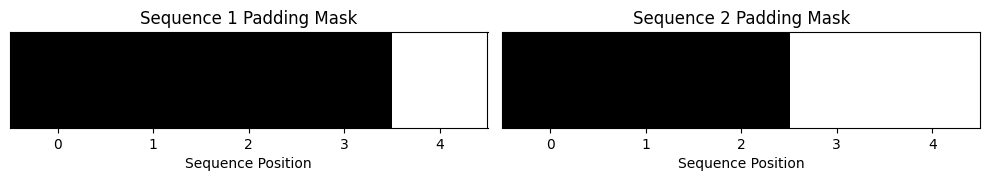

In [15]:
# Visualize the padding mask
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
for i in range(batch_size):
    mask_np = padding_mask[i].int().numpy().reshape(1, -1)
    ax[i].imshow(mask_np, cmap='binary', interpolation='none')
    ax[i].set_title(f"Sequence {i+1} Padding Mask")
    ax[i].set_yticks([])
    ax[i].set_xticks(range(seq_len))
    ax[i].set_xlabel("Sequence Position")
plt.tight_layout()
plt.show()

In [16]:
# Forward pass with padding mask
print("\nMulti-Head Attention Forward Pass with Padding Mask:")
output1, attn_weights1 = mha(x, x, x, mask=padding_mask, return_attention=True)

print("\n Attention Weights:")
print(attn_weights1)

print("\n Attention Output:")
print(output1)


Multi-Head Attention Forward Pass with Padding Mask:

 Attention Weights:
tensor([[[[0.3530, 0.2134, 0.3160, 0.2288, 0.0000],
          [0.4236, 0.0000, 0.2284, 0.2353, 0.0000],
          [0.2325, 0.2582, 0.2661, 0.3543, 0.0000],
          [0.0000, 0.0000, 0.3035, 0.4107, 0.0000],
          [0.4169, 0.2345, 0.2214, 0.2384, 0.0000]],

         [[0.4721, 0.1246, 0.3224, 0.1919, 0.0000],
          [0.2426, 0.4377, 0.2253, 0.2055, 0.0000],
          [0.2896, 0.2427, 0.3929, 0.1859, 0.0000],
          [0.2422, 0.3457, 0.2554, 0.2678, 0.0000],
          [0.3366, 0.3192, 0.1673, 0.2881, 0.0000]],

         [[0.0000, 0.1672, 0.2553, 0.3768, 0.0000],
          [0.1764, 0.2204, 0.3707, 0.3436, 0.0000],
          [0.0000, 0.1397, 0.3655, 0.3663, 0.0000],
          [0.1944, 0.0000, 0.2132, 0.3025, 0.0000],
          [0.3098, 0.2585, 0.3343, 0.2085, 0.0000]],

         [[0.4220, 0.1968, 0.2224, 0.2699, 0.0000],
          [0.2770, 0.2666, 0.2717, 0.2958, 0.0000],
          [0.4363, 0.2314, 0.1886, 

### Example 2: Using Causal Mask

Used in decoder self-attention to prevent attending to future tokens
- **Dimensions**: 1, seq_len, seq_len] = [1, 5, 5]
- **Values**: Lower triangular matrix of 1s (tokens can only attend to previous positions)

In [17]:
# causal mask (for autoregressive/decoder attention)
causal_mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0)
print(causal_mask.shape, '\n')

causal_mask

torch.Size([1, 5, 5]) 



tensor([[[1., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0.],
         [1., 1., 1., 0., 0.],
         [1., 1., 1., 1., 0.],
         [1., 1., 1., 1., 1.]]])

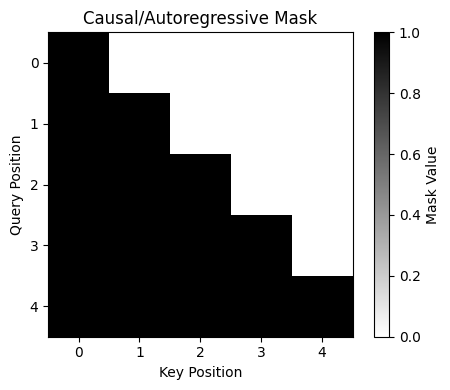

In [18]:
# Visualize the causal mask
plt.figure(figsize=(5, 4))
plt.imshow(causal_mask[0].numpy(), cmap='binary')
plt.title("Causal/Autoregressive Mask")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.colorbar(label="Mask Value")
plt.tight_layout()
plt.show()

In [19]:
# Forward pass with causal mask
print("\nMulti-Head Attention Forward Pass with Causal Mask:")
output2, attn_weights2 = mha(x, x, x, mask=causal_mask, return_attention=True)

print("\n Attention Weights:")
print(attn_weights2)

print("\n Attention Output:")
print(output2)


Multi-Head Attention Forward Pass with Causal Mask:

 Attention Weights:
tensor([[[[1.1111, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.7269, 0.3843, 0.0000, 0.0000, 0.0000],
          [0.3414, 0.3791, 0.3907, 0.0000, 0.0000],
          [0.0000, 0.2375, 0.3035, 0.4107, 0.0000],
          [0.3401, 0.1913, 0.1806, 0.1944, 0.2047]],

         [[1.1111, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.3962, 0.7149, 0.0000, 0.0000, 0.0000],
          [0.3478, 0.2915, 0.4718, 0.0000, 0.0000],
          [0.2422, 0.3457, 0.2554, 0.2678, 0.0000],
          [0.2747, 0.2605, 0.1365, 0.2351, 0.2042]],

         [[1.1111, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.4939, 0.6172, 0.0000, 0.0000, 0.0000],
          [0.3575, 0.2084, 0.5453, 0.0000, 0.0000],
          [0.1944, 0.4010, 0.2132, 0.0000, 0.0000],
          [0.2127, 0.1775, 0.2296, 0.1432, 0.3480]],

         [[1.1111, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.5662, 0.5449, 0.0000, 0.0000, 0.0000],
          [0.5662, 0.0000, 0.2447, 0

### Attention Pattern Visualization

In [20]:
def plot_attention_patterns(attention_weights, titles):
    """Plot attention patterns from multiple attention heads."""
    fig, axes = plt.subplots(2, 4, figsize=(15, 6))
    axes = axes.flatten()
    
    # Get the first sequence from the batch
    seq_attention = attention_weights[0]  # [num_heads, seq_len, seq_len]
    
    for h in range(num_heads):
        ax = axes[h]
        att = seq_attention[h].detach().numpy()
        im = ax.imshow(att, cmap='viridis')
        ax.set_title(f"{titles} - Head {h+1}")
        ax.set_xlabel("Key Position")
        ax.set_ylabel("Query Position")
    
    fig.colorbar(im, ax=axes.ravel().tolist())
    plt.tight_layout()
    plt.show()

C:\Users\uzair\AppData\Local\Temp\ipykernel_28444\4282585730.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


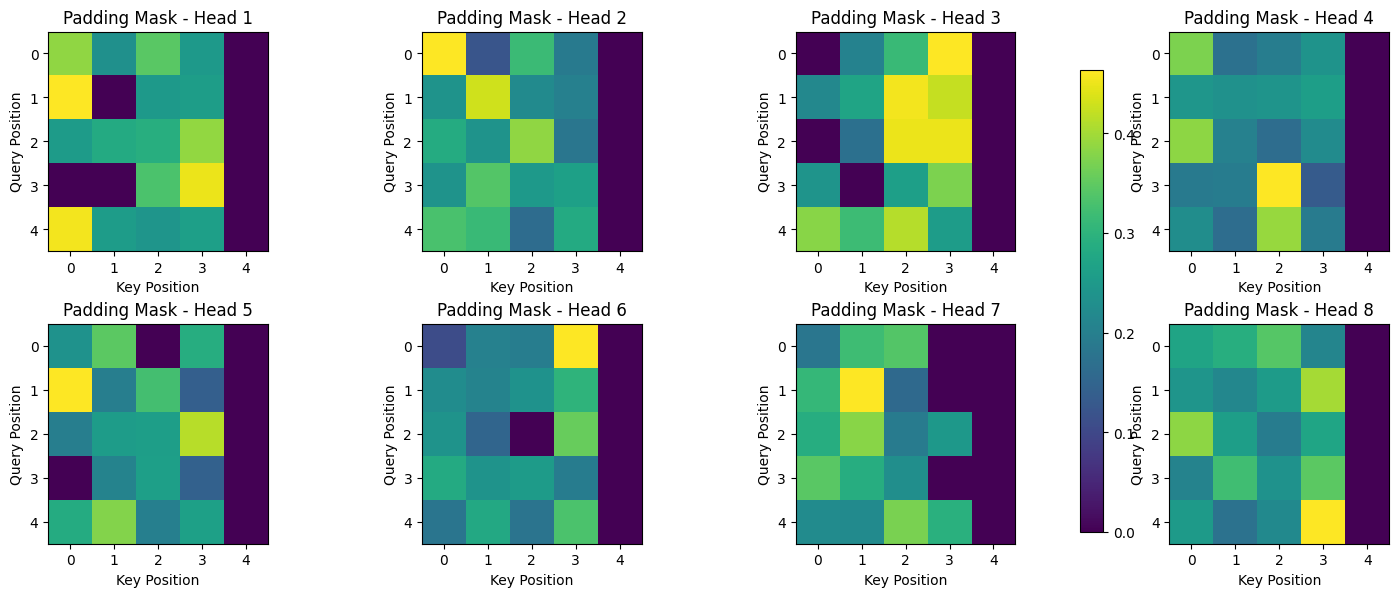

In [21]:
plot_attention_patterns(attn_weights1, "Padding Mask")

C:\Users\uzair\AppData\Local\Temp\ipykernel_28444\4282585730.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


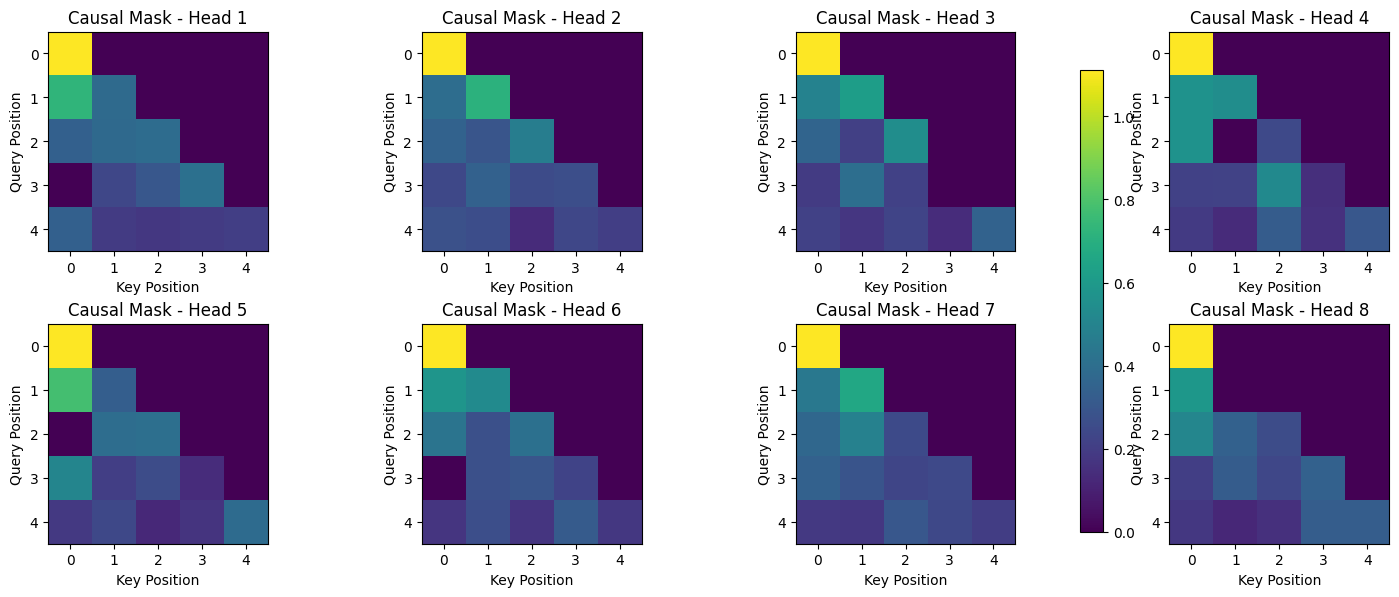

In [22]:
plot_attention_patterns(attn_weights2, "Causal Mask")